# Sentiment Analysis over filtered dataframs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

plt.style.use('ggplot')

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
folder = "../factored-datathon-2023-data-science-rockstars/final_ahora_si_talvez/Games"
# folder = "../factored-datathon-2023-data-science-rockstars/GroupedAndGames/games"
files = [file for file in os.listdir(folder) if file.endswith('.gzip')]

# Leer todos los archivos y almacenarlos en una lista
dataframes = []
for file in files:
    ruta_archivo = os.path.join(folder, file)
    df = pd.read_parquet(ruta_archivo, engine='fastparquet')
    dataframes.append(df)

# Combinar los DataFrames en uno solo
df = pd.concat(dataframes, ignore_index=True)
df['id'] = df.reset_index().index

In [4]:
len(df['style'].unique())
# df.shape

810

<Axes: ylabel='style'>

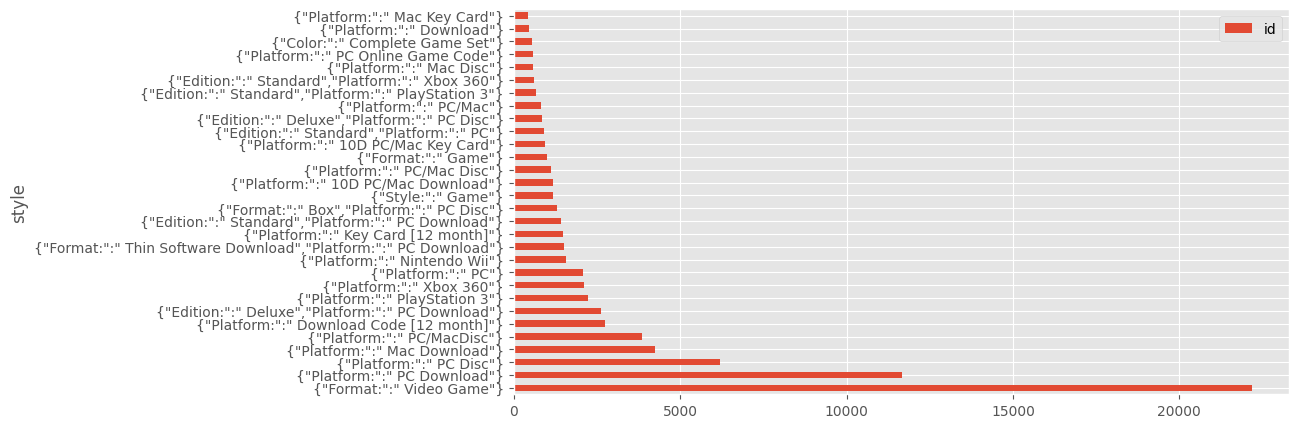

In [5]:
## Horizontal bar chart
df[['style','id']].groupby('style').count().sort_values(by='id',ascending=False).head(30).plot(kind='barh',figsize=(10,5))

<Axes: ylabel='style'>

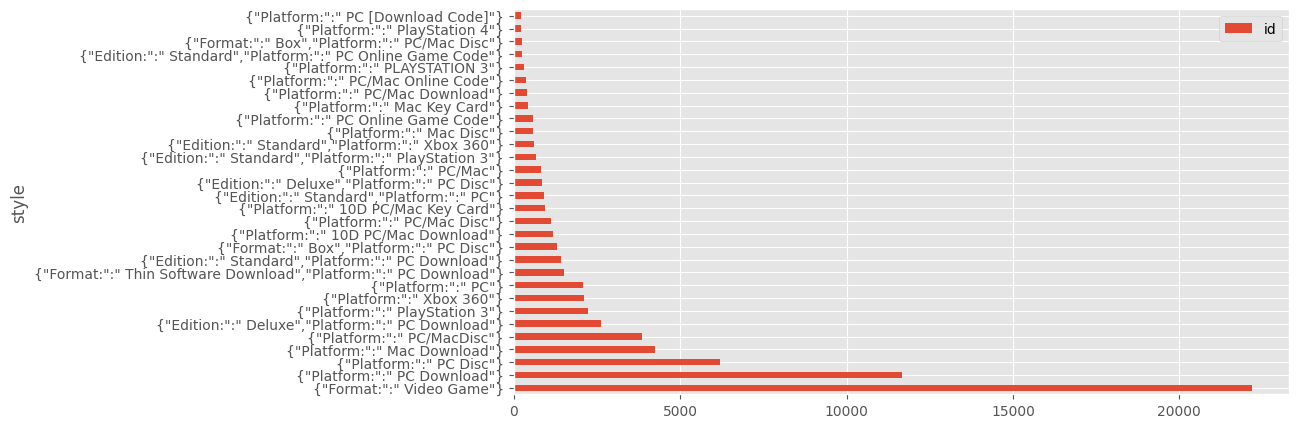

In [6]:
filtered_df = df[df['style'].str.contains('Video Game|PC|Xbox|PlayStation|Mac', regex=True,case=False, na=False)]
filtered_df[['style','id']].groupby('style').count().sort_values(by='id',ascending=False).head(30).plot(kind='barh',figsize=(10,5))

In [7]:
filtered_df.shape

(77202, 10)

In [8]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [9]:
def polarity_score_roberta(text):
    """
    Returns polarity score of the text using Roberta model
    """
    encoded_text = tokenizer(text,return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative': scores[0],
        'neutral': scores[1],
        'positive': scores[2]
    }

    return scores_dict

In [11]:
res ={}

for i, row in tqdm(filtered_df.iterrows(),total = len(filtered_df)):
    try:
        try:
            try:
                text = row['reviewText']
                myid = row['id']
                roberta_result = polarity_score_roberta(text)
                res[myid] = roberta_result
            except RuntimeError:
                # print(f'Broke for id {myid}')
                continue
        except ValueError:
            # print(f'ValueError for id {myid}')
            continue
    except IndexError:
        # print(f'IndexError for id {myid}')
        continue

  0%|          | 0/77202 [00:00<?, ?it/s]

100%|██████████| 77202/77202 [6:01:27<00:00,  3.56it/s]   


NameError: name 'roberta' is not defined

In [12]:
res_filtered = pd.DataFrame(res).T
res_filtered = res_filtered.reset_index().rename(columns={'index': 'id'})
res_filtered.to_parquet('res_filtered.parquet')

In [14]:
res_filtered.shape

(75891, 4)